## Введение

Пусть имеется размеченный граф $G(V, E, L)$. Тогда конечный автомат построенный по этому графу (рёбра → переходы, вершины → состояния) допускает регулярный язык $L_G$

Пусть имеется регулярное выражение $R$, задающее регулярный язык ограничений $L_R$

Рассмотрим задачу $RPQ = \{(v_i, v_j) \; | \;\exists\pi:w(v_i \; \pi \;  v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_R$, $V_S \in V$ --- множество стартовых вершин и $V_F \in V$ --- множество финальных вершин, а также её подраздел $RPQ_{BFS}$, в котором достижимость определяется не между всеми парами вершин, а между $V_S$ и $V_F$

Важным этапом решения задачи $RPQ$ является построение языка пересечения, который задается пересечением двух конечных автоматов $КА_{G}$ и $КА_{R}$.

По определению $КА_3 = КА_1\cap КА_2 = (S^{1}\times S^{2}, \Delta^{3}, S^{1}_S\times S^{2}_S, S^{1}_F\times S^{2}_F)$, где функция переходов задаётся как
$\Delta^{3}: (v_i, v_j)\times l \rightarrow (u_i, u_j)$

$
\begin{cases}
v_i\in S^{1}\times l\rightarrow u_i\in S^{1}\quad\in\Delta^{1} \\
v_j\in S^{2}\times l\rightarrow u_j\in S^{2}\quad\in\Delta^{2}
\end{cases}$

Для построения функции переходов воспользуемся алгоритмом, основанным на тензорном произведении матриц смежностей конечных автоматов. 

Для решения задачи $PRQ_{BFS}$ необходимо построение прямой суммы матриц смежностей конечных автоматов и пошаговое умножение полученной суммы на матрицу текущих местоположений алгоритма $BFS$.

В данной работе будут исследованы алгоритмы решения задач $RPQ$ и $RPQ_{BFS}$, основанные на разных реализациях алгоритма пересечения конечных автоматов.

## Постановка задачи
Задача посвящена анализу производительности различных реализаций алгоритма решения задач $RPQ$:
- Достижимость между всеми парами вершин
- Достижимость для всего множества заданных вершин
- Достижимость для каждой из заданного множества стартовых вершин.

В ходе исследования должны быть даны ответы на следующие вопросы:
- При каких условиях использование специализированных библиотек разреженной линейной алгебры даёт выигрыш в производительности? Для каждой из трёх задач.
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные? (При использовании специализированных библиотек)
- На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях? (При использовании специализированных библиотек)

Для экспериментального исследования алгоритмов для регулярных запросов необходимо:
- Используя [pyCuBool](https://pypi.org/project/pycubool/) или [pygraphblas](https://github.com/Graphegon/pygraphblas) реализовать алгоритмы решения задач $RPQ$ и $RPQ_{BFS}$;
- Подключить написанные алгоритмы решения задач $RPQ$ и $RPQ_{BFS}$ из Заданий 3, 4;
- Сформировать набор данных для экспериментов;
- Произвести сравнительный анализ производительности алгоритмов.

## Исследуемые решения
Элементами матрицы смежности конечного автомата являются подмножества его меток. Чтобы не вводить операцию пересечения множеств в тензорном произведении, матрицы смежности двух конечных автоматов приводятся к виду булевых матриц, которые на практике являются сильно разреженными.

В качестве библиотеки для реализации алгоритмов $RPQ$ и $PRQ_{BFS}$ была выбрана библиотека [pyCuBool](https://pypi.org/project/pycubool/), так как она предоставляет оптимизированные вычисления на GPU именно для разреженных булевых матриц, а также написана Егором Орачевым, проверяющим задания по данному курсу, что позволит оперативно получить ответы по работе библиотеки, если таковые возникнут. 

Таким образом сравниваемые алгоритмы используют различные библиотеки для работы с разреженными матрицами:
- [pyCuBool](https://pypi.org/project/pycubool/)
- [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)

В scipy.sparce используются `csr` матрицы, в pyCuBool – встроенный класс матрицы, операции с объектами которого оптимизированы под GPU.

## Подготовка окружения
Для работы с датасетом `cfpq_data` необходим python версии >= 3.8, поэтому для начала надо обновить python

In [1]:
# Установка проекта 
!git clone -b task_5_pr https://github.com/Nikita-Fast/formal-lang-course.git

Cloning into 'formal-lang-course'...
remote: Enumerating objects: 859, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 859 (delta 8), reused 16 (delta 3), pack-reused 829
Receiving objects: 100% (859/859), 2.26 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [2]:
%%capture
# Установка зависимостей проекта
!pip install -r formal-lang-course/requirements.txt
# Установка библиотеки pycubool
!pip install pycubool

# Установка библиотек для красивых графиков
!pip install matplotlib
!pip install seaborn

In [3]:
# Подключение директории проекта
import sys
sys.path.insert(1, "formal-lang-course")

## Описание данных для экспериментов

В качестве $G$ будем использовать графы из [cfpq-data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html) датасета.

В частности 4 маленьких графов и 2 больших графов, ограничение по величине графов наложено характеристиками оборудования, которое предоставляет бесплатный тариф Google Colab (к примеру, на графах [mm](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/mm.html#mm) и [apache](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/apache.html#apache) обычный $RPQ$ падает, т.к. исчерпан лимит ОЗУ).

В запросах должны использоваться все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива).

In [4]:
GRAPH_NAMES = ["skos", "bzip", "pr", "atom", "enzyme", "go_hierarchy"]

In [5]:
# Информация о графах

from project.graph_tools import get_graph_info, load_graph
import pandas as pd 
import cfpq_data

edges = []
nodes = []

for graph_name in GRAPH_NAMES:
    graph_info = get_graph_info(load_graph(graph_name))
    edges.append(graph_info.edges)
    nodes.append(graph_info.nodes)


df = pd.DataFrame(
    {
        "Edges": edges,
        "Nodes": nodes,
    },
    index=GRAPH_NAMES
)
df

import sources directory


,Edges,Nodes
skos,252,144
bzip,556,632
pr,692,815
atom,425,291
enzyme,86543,48815
go_hierarchy,490109,45007


## Регулярные запросы

Все запросы к графам отвечают следующим шаблонам, где $L_i$ — метки графа:
- $(L_0 | L_1 | L_2)^* \: L_3$
- $(L_0 | L_2)$+ ${L_1}^*$
- $L_0\,L_1\,L_2\,(L_3 | L_1)^*$
- $(L_0 | L_3)^*\,\,|\,\,(L_1 | L_2)^*$
- $(L_0 L_1 L_2)^* | L_3$

### Крайний случай
Если в графе число меток меньше числа запросов, тогда метки дополняются уже имеющимися. (В графе должна быть по крайней мере 1 метка, иначе эксперимент не имеет смысла)

In [6]:
# Генерация регулярных выражений

from pyformlang.regular_expression.regex_objects import Symbol
from pyformlang.regular_expression import Regex

NUMBER_OF_REGEX = 5

def regex_from_label(label):
    regex = Regex("")
    regex.head = Symbol(str(label))
    return regex

def expand(lst, expand_size):
    """
    If number of labels < NUMBER_OF_REGEX, then expand them with existing ones
    """
    expand_length = expand_size - len(lst)
    if expand_length <= 0:
        return lst
    expanded_lst = lst.copy()
    for i in range(expand_length):
        expanded_lst.append(expanded_lst[i])
    return expanded_lst

def regex_first(labels):
    """
    (l0 | l1 | l2)* l3
    """
    labels = expand(labels, NUMBER_OF_REGEX)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.union(regex_1).union(regex_2).kleene_star().concatenate(regex_3)
  

def regex_second(labels):
    """
    (l0 | l2)+ l1*
    """
    labels = expand(labels, NUMBER_OF_REGEX)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    return regex_0.union(regex_2).union(regex_1.kleene_star())

def regex_third(labels):
    """
    l0 l1 l2 (l3 | l1)*
    """ 
    labels = expand(labels, NUMBER_OF_REGEX)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).concatenate((regex_3.union(regex_1)).kleene_star())

def regex_fourth(labels):
    """
    (l0 | l3)* | (l1 | l2)*
    """
    labels = expand(labels, NUMBER_OF_REGEX)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    left_regex = (regex_0.union(regex_3)).kleene_star()
    right_regex = (regex_1.union(regex_2)).kleene_star()
    return left_regex.union(right_regex)

def regex_fifth(labels):
    """
    (l0 l1 l2)* | l3
    """
    labels = expand(labels, NUMBER_OF_REGEX)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).kleene_star().union(regex_3)

REGEX_GENERATORS = (regex_first, regex_second, regex_third, regex_fourth, regex_fifth)

## Алгоритм, использующий pyCuBool
В ячейках ниже представлены класс для выполнения пересечения конечных автоматов, заданных в виде их булевых матриц, а также алгоритмы решения задач $RPQ$ и $RPQ_{BFS}$. 

#### Класс для декомпозиции конечного автомата в качестве булевых матриц библиотеки `pycubool`

In [7]:
"""
Декомпозиция автомата в качестве булевых матриц
"""

import pycubool as cb

from pyformlang.finite_automaton import (
    State,
    NondeterministicFiniteAutomaton,
    FiniteAutomaton,
)


class CuBoolAutomaton:
    """
    Class representing boolean matrix decomposition of finite automaton
    """

    def __init__(self):
        self.num_states = 0
        self.start_states = set()
        self.final_states = set()
        self.bool_matrices = {}
        self.state_indices = {}

    @classmethod
    def from_automaton(cls, automaton: FiniteAutomaton):
        """
        Transform automaton to set of labeled boolean matrix
        Parameters
        ----------
        automaton
            Automaton for transforming

        Returns
        -------
        CuBoolAutomaton
            Result of transforming
        """

        automaton_matrix = cls()
        automaton_matrix.num_states = len(automaton.states)
        automaton_matrix.start_states = automaton.start_states
        automaton_matrix.final_states = automaton.final_states
        automaton_matrix.state_indices = {
            state: idx for idx, state in enumerate(automaton.states)
        }
        for s_from, trans in automaton.to_dict().items():
            for label, states_to in trans.items():
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for s_to in states_to:
                    idx_from = automaton_matrix.state_indices[s_from]
                    idx_to = automaton_matrix.state_indices[s_to]
                    if label not in automaton_matrix.bool_matrices.keys():
                        automaton_matrix.bool_matrices[label] = cb.Matrix.empty(shape=(automaton_matrix.num_states, automaton_matrix.num_states))
                    automaton_matrix.bool_matrices[label][idx_from, idx_to] = True

        return automaton_matrix


    def to_automaton(self) -> NondeterministicFiniteAutomaton:
        """
        Transform set of labeled boolean matrix to automaton.

        Parameters
        ----------
        self
            Set of boolean matrix with label as key

        Returns
        -------
        CuBoolAutomaton
            Resulting automaton
        """

        automaton = NondeterministicFiniteAutomaton()
        for label in self.bool_matrices.keys():
            for s_from, s_to in self.bool_matrices[label]:
                automaton.add_transition(s_from, label, s_to)

        for state in self.start_states:
            automaton.add_start_state(State(state))

        for state in self.final_states:
            automaton.add_final_state(State(state))

        return automaton

    @property
    def get_states(self):
        return self.state_indices.keys()

    @property
    def get_start_states(self):
        return self.start_states.copy()

    @property
    def get_final_states(self):
        return self.final_states.copy()

    def get_transitive_closure(self):
        """
        Get transitive closure of sparse.csr_matrix

        Parameters
        ----------
        self
            Class exemplar

        Returns
        -------
            Transitive closure
        """

        shape = list(self.bool_matrices.values())[0].shape
        tc = cb.Matrix.empty(shape=shape)

        if len(self.bool_matrices) != 0:
            for elem in self.bool_matrices.values():
                tc = tc.ewiseadd(elem)
            prev_nnz = tc.nvals
            new_nnz = 0

            while prev_nnz != new_nnz:
                tc.mxm(tc, out=tc, accumulate=True)  # t += t * t
                prev_nnz, new_nnz = new_nnz, tc.nvals

        return tc

    def intersect(self, other):
        """
        Get intersection of two automatons
        Parameters
        ----------
        self
            First automaton
        other
            Second automaton

        Returns
        -------
        CuBoolAutomaton
            Result of intersection
        """
        intersection = CuBoolAutomaton()
        common_labels = self.bool_matrices.keys() & other.bool_matrices.keys()

        for label in common_labels:
            intersection.bool_matrices[label] = self.bool_matrices[label].kronecker(other.bool_matrices[label])

        for state_lhs, s_lhs_index in self.state_indices.items():
            for state_rhs, s_rhs_index in other.state_indices.items():
                new_state = new_state_idx = (
                    s_lhs_index * other.num_states + s_rhs_index
                )
                intersection.state_indices[new_state] = new_state_idx

                if state_lhs in self.start_states and state_rhs in other.start_states:
                    intersection.start_states.add(new_state)

                if state_lhs in self.final_states and state_rhs in other.final_states:
                    intersection.final_states.add(new_state)

        return intersection

#### Реализация RPQ на `pycubool`

In [8]:
"""
Ячейка с алгоритмом решения RPQ
"""

from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex
from project.automata_tools import regex_to_minimal_dfa, create_nfa_from_graph


def rpqCB(
    graph: MultiDiGraph, regex: Regex, start_nodes: set = None, final_nodes: set = None
):
    graph_automaton_matrix = CuBoolAutomaton.from_automaton(
        create_nfa_from_graph(graph, start_nodes, final_nodes)
    )
    regex_automaton_matrix = CuBoolAutomaton.from_automaton(
        regex_to_minimal_dfa(regex)
    )

    intersection = graph_automaton_matrix.intersect(regex_automaton_matrix)
    tc = intersection.get_transitive_closure()

    result = set()
    for state_from, state_to in tc:
        if (
            state_from in intersection.start_states
            and state_to in intersection.final_states
        ):
            result.add(
                (
                    state_from // regex_automaton_matrix.num_states,
                    state_to // regex_automaton_matrix.num_states,
                )
            )

    return result

#### Реализация $RPQ_{BFS}$ на `pycubool`

In [9]:
import pycubool as pb
from typing import List

import networkx as nx

# from project.boolean_matrices import BooleanMatrices
from project.automata_tools import regex_to_minimal_dfa
from project.automata_tools import graph_to_nfa
from pyformlang.regular_expression import Regex
from pyformlang.finite_automaton import DeterministicFiniteAutomaton


def _build_direct_sum(
    r: DeterministicFiniteAutomaton, g: nx.MultiDiGraph
) -> cb.Matrix:
    """
    Build direct sum of boolean matrix decomposition dfa and graph

    Parameters
    ----------
    r: DeterministicFiniteAutomaton
        Input dfa
    g: nx.MultiDiGraph
        Input graph

    Returns
    -------
    d: 
        Result of direct sum
    """

    d = {}

    r_matrix = CuBoolAutomaton.from_automaton(r)
    g_matrix = CuBoolAutomaton.from_automaton(graph_to_nfa(g))

    r_labels = set(r_matrix.bool_matrices.keys())
    g_labels = set(g_matrix.bool_matrices.keys())
    labels = r_labels.intersection(g_labels)

    r_size = r_matrix.num_states
    g_size = g_matrix.num_states
    for label in labels:
        result_size = r_size + g_size
        result = cb.Matrix.empty(shape=(result_size, result_size))
        for x, y in r_matrix.bool_matrices[label]:
            result[x, y] = True
        for x, y in g_matrix.bool_matrices[label]:
            x += r_size
            y += r_size
            result[x, y] = True

        d[label] = result
    return d


def _create_masks(
    r: DeterministicFiniteAutomaton, g: nx.MultiDiGraph
) -> cb.Matrix:
    """
    Create M matrix

    Parameters
    ----------
    r: DeterministicFiniteAutomaton
        Input dfa
    g: nx.MultiDiGraph
        Input graph

    Returns
    -------
    m: cb.Matrix

    """

    r_size = len(r.states)
    g_size = len(g.nodes)
    m = cb.Matrix.empty(shape=(r_size, r_size + g_size))
    for i, state in enumerate(r.states):
        if state in r.start_states:
            m[i, i] = True

    return m


def _set_start_verts(m: cb.Matrix, v_src: set) -> cb.Matrix:
    """
    Add start vertices to right part of M matrix

    Parameters
    ----------
    m: cb.Matrix
        M matrix
    v_src: set
        Start vertices set

    Returns
    -------
    m_new: cb.Matrix
        Updated M matrix
    """
    r_size = m.shape[0]
    for i in range(r_size):
        for start_v in v_src:
            m[i, r_size + start_v] = True

    return m


def _get_graph_labels(g: nx.MultiDiGraph) -> set:
    """
    Extract graph labels from edges

    Parameters
    ----------
    g: nx.MultiDiGraph
        Input graph

    Returns
    -------
    labels: set[str]
        Extracted labels
    """

    labels = set()
    for node_from, node_to in g.edges():
        labels.add(g.get_edge_data(node_from, node_to)[0]["label"])

    return labels


def _extract_left_submatrix(m: cb.Matrix) -> cb.Matrix:
    """
    Extract left part of M matrix --- identity matrix

    Parameters
    ----------
    m: cb.Matrix
        M matrix

    Returns
    -------
    m: cb.Matrix
        Identity matrix
    """

    extr_size = m.shape[0]
    return m[:, :extr_size]


def _extract_right_submatrix(m: cb.Matrix) -> cb.Matrix:
    """
    Extract right part of M matrix --- front

    Parameters
    ----------
    m: cb.Matrix
        M matrix

    Returns
    -------
    m: cb.Matrix
        Front
    """

    extr_size = m.shape[0]
    return m[:, extr_size:]


def _transform_front_part(front_part: cb.Matrix) -> cb.Matrix:
    """
    Transform another front to right form of M matrix. Left submatrix is identity matrix

    Parameters
    ----------
    front_part: cb.Matrix
        Input matrix

    Returns
    -------
    m: cb.Matrix
        Transformed matrix
    """

    t = _extract_left_submatrix(front_part)
    m_new = cb.Matrix.empty(front_part.shape)
    nnz_row, nnz_col = t.to_lists()
    for i in range(len(nnz_col)):
        row = front_part.extract_row(nnz_row[i])
        for j in row.to_list():
            m_new[nnz_col[i], j] = True
    return m_new


def _cb_bfs_based_rpq(
    r: DeterministicFiniteAutomaton, g: nx.MultiDiGraph, v_src: set, separated=False
) -> List[cb.Matrix]:
    """

    Parameters
    ----------
    r: DeterministicFiniteAutomaton
        Input dfa
    g: nx.MultiDiGraph
        Input graph
    v_src: set
        Start vertices set
    separated: bool
        Process for each start vertex or for set of start vertices

    Returns
    -------
    visited: List[cb.Matrix]
        List of matrices in two parts. In the first part of the square matrix with the state of the automata,
        in the second part of the matrix with ones in the columns,
        the vertices of which can be found from the state of the automaton of this row
    """
    d = _build_direct_sum(r, g)
    if separated:
        init_m = [
            _set_start_verts(_create_masks(r, g), {start_vertex})
            for start_vertex in v_src
        ]
    else:
        init_m = _create_masks(r, g)
        init_m = [_set_start_verts(init_m, v_src)]

    labels = r.symbols.intersection(_get_graph_labels(g))

    old_nnz = []
    for front_matrix in init_m:
        old_nnz.append(0)
    is_continue = True
    visited = []
    for front_matrix in init_m:
        visited.append(front_matrix.dup())
    not_updated_matrix = set()  # matrix numbers in which nnz counts do not change

    while is_continue:
        is_continue = False
        for num_front_matrix in range(len(init_m)):
            # not processing unchanged matrix
            if num_front_matrix in not_updated_matrix:
                continue
            new_front = cb.Matrix.empty(init_m[num_front_matrix].shape)
            for label in labels:
                # multiply D matrix and current front
                temp = init_m[num_front_matrix].mxm(d[label])
                # transform to right form
                new_front = new_front.ewiseadd(_transform_front_part(temp))
                visited[num_front_matrix] = visited[num_front_matrix].ewiseadd(new_front)  # update visited vertices

            # change front to new
            init_m[num_front_matrix] = new_front.dup()

            # count nonzero values
            if old_nnz[num_front_matrix] == visited[num_front_matrix].nvals:
                not_updated_matrix.add(num_front_matrix)
            else:
                old_nnz[num_front_matrix] = visited[num_front_matrix].nvals
                is_continue = True
    return visited


def cb_bfs_rpq(
    graph: nx.MultiDiGraph,
    regex: Regex,
    start_vertices: set = None,
    final_vertices: set = None,
    separated: bool = False,
) -> set:
    """
    Get set of reachable pairs of graph vertices

    Parameters
    ----------
    graph
        Input Graph
    regex
        Input regular expression
    start_vertices
        Start vertices for graph
    final_vertices
        Final vertices for graph
    separated
        Process for each start vertex or for set of start vertices

    Returns
    -------
    set
        Set of reachable pairs of graph vertices
    """
    if start_vertices is None:
        start_vertices = set()
        for node in graph.nodes:
            start_vertices.add(node)
    if final_vertices is None:
        final_vertices = set()
        for node in graph.nodes:
            final_vertices.add(node)

    regex_automaton = regex_to_minimal_dfa(regex)
    rpq_result = _cb_bfs_based_rpq(
        regex_automaton, graph, v_src=start_vertices, separated=separated
    )

    res = set()
    if separated:
        for s_v in start_vertices:
            visited_per_start = _extract_right_submatrix(rpq_result[s_v])
            temp = list()
            for i, automaton_state in enumerate(regex_automaton.states):
                if not (automaton_state in regex_automaton.final_states):
                    continue
                row = visited_per_start.extract_row(i)
                for vertex in row:
                    if vertex in final_vertices:
                        temp.append(vertex)
            res.add((s_v, frozenset(temp)))
    else:
        reachable_vertices = list()
        visited_per_start = _extract_right_submatrix(rpq_result[0])
        for i, automaton_state in enumerate(regex_automaton.states):
            if not (automaton_state in regex_automaton.final_states):
                continue
            row = visited_per_start.extract_row(i)
            for vertex in row:
                if vertex in final_vertices:
                    reachable_vertices.append(vertex)
        res.add(frozenset(reachable_vertices))
    return res


In [10]:
from project.rpq_better import rpq

In [11]:
from project.rpq_better import bfs_rpq

## Описание эксперимента

### Первый вопрос (о использовании специализированных библиотек)
Для выяснения того, при каких условиях использование `pycubool` даёт выигрыш в производительности против использования `scipy`, необходимо выделить основные вычислительно-ёмкие этапы алгоритмов. Вполне очевидно, что основными характеристиками влияющими на скорость выполнения являются размер матриц и реализация алгебраических операций над ними.

Таким образом, для каждой из трёх задач следует замерить скорость работы их реализаций на `scipy` и `pycubool` на выбранных графах и регулярных выражениях  и проследить зависимость разницы данных скоростей от указанных характеристик.

### Второй вопрос (о стартовом множестве)
Для получения ответа на данный вопрос необходимо замерить и проанализировать скорость работы решений первой и третьей задач, реализованных на `pycubool`, на выбранных графах и регулярных выражениях при различных размерах стартового множества вершин.

### Третий вопрос (о сравнении второй и третьей задач)
Чтобы выяснить, насколько реализация на `pycubool` решения второй задачи медленнее решения третьей задачи при одинаковых начальных условиях нужно замерить время их работы на одинаковых графах и регулярных запросах с одинаковыми стартовыми множествами вершин и сравнить результаты.

### Замеры
Таким образом для ответа на поставленные вопросы достаточно провести следующие замеры времени исполнения исследуемых реализаций:

- на выбранных графах и регулярных выражениях с фиксированным множеством стартовых вершин --- для всех задач и реализаций;
- на выбранных графах, регулярных выражениях и различных размерах множества стартовых вершин --- для реализаций на `pycubool` первой и третьей задач.

#### Дополнение
Для маленьких графов время выполнения функции построения $RPQ$ и $RPQ_{BFS}$ для каждого запроса замеряется 5 раз и затем берётся среднее и максимальное. Для больших графов время выполнение функции замеряется единожды для каждого запроса. Данное решение обосновано незначительностью погрешности времени выполнения на больших графах и вычислительными возможностями бесплатного тарифа Google Colab.

Множество финальных вершин влияет на быстродействие всех трёх алгоритмов одинаково: во всех случаях на завершающем этапе достигнутые вершины проверяются на принадлежность к множеству финальных вершин, что происходит через поиск по множеству. Поэтому для упрощения в качестве множества финальных вершин выбиралось всё множество вершин графа.

### Характеристики оборудования

In [12]:
# Сведения об операционной системе
!cat /etc/os-release

NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


In [13]:
# Сведения об используемом CPU
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Socket(s):                       1
Core(s) per socket:              1
Thread(s) per core:              2
CPU MHz:                         2000.146


In [14]:
# Сведения об используемом GPU
!nvidia-smi

Mon Mar 20 09:05:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# Сведения о размере оперативной памяти системы в GB
!echo 'Total RAM (GB)'
!awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

Total RAM (GB)
12.6812


### Проведение эксперимента

In [16]:
# Подготовка параметров запросов 

import networkx as nx

# размер множества стартовых вершин в процентах от количества вершин графа
start_vertices_size = [0.005, 0.01, 0.015, 0.02, 0.05]
NUMBER_SIZE = len(start_vertices_size)

# Форма запроса --- размер стартового множества и регулярное выражение
# Параметры для замеров с фиксированным множеством стартовых вершин
# Регулярные выражения описанные выше и четверть множества вершин в качестве стартового
METAPARAMS_FIX = [(0.02, regex) for regex in REGEX_GENERATORS]

# Параметры для замеров с переменным множеством стартовых вершин
# Регулярные выражения описанные выше и процент от количества вершин графа в качестве множества стартовых вершин
METAPARAMS = [(size, regex) for regex in REGEX_GENERATORS
              for size in start_vertices_size
              ]

LAUNCH_AT_SMALL = 5
LAUNCH_AT_LARGE = 1

In [17]:
import pandas as pd

# Описание запросов для замеров с постоянным множеством стартовых вершин
metaparams_desc_fix_size = [regex.__doc__.strip().strip('\n') 
                    for regex in REGEX_GENERATORS
]

# Описание запросов для замеров с переменным множеством стартовых вершин
metaparams_desc = [regex.__doc__.strip().strip('\n') + " " + str(size)
                    for regex in REGEX_GENERATORS
                    for size in start_vertices_size
]

# Метрики: среднее время, максимальное время
# Из-за маленького количества данных полученных в результате замеров (для больших графов одно значение)
# было принято решение не включать сложные метрики в виду их неинформативности

# RPQ. Первая задача
df_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

df_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

# BFS RPQ вида множество -> множество. Вторая задача
df_bfs_ns_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_bfs_ns_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

df_bfs_ns_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_bfs_ns_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

# BFS RPQ вида каждая -> множество. Третья задача
df_bfs_sep_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_bfs_sep_rpq_mean_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

df_bfs_sep_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)
df_cb_bfs_sep_rpq_max_fix_size = pd.DataFrame(index=metaparams_desc_fix_size, columns=GRAPH_NAMES)

# Таблицы для хранения данных о замерах с переменным множеством стартовых вершин
# RPQ. Первая задача
df_cb_rpq_mean = pd.DataFrame(index=metaparams_desc, columns=GRAPH_NAMES)
df_cb_rpq_max = pd.DataFrame(index=metaparams_desc, columns=GRAPH_NAMES)

# BFS RPQ вида каждая -> множество. Третья задача
df_cb_bfs_sep_rpq_mean = pd.DataFrame(index=metaparams_desc, columns=GRAPH_NAMES)
df_cb_bfs_sep_rpq_max = pd.DataFrame(index=metaparams_desc, columns=GRAPH_NAMES)

In [18]:
import signal
import time
import cfpq_data

from project.graph_tools import load_graph, GraphInfo, get_graph_info

def signal_handler(signum, frame):
    raise Exception("Timed out!")

signal.signal(signal.SIGALRM, signal_handler)

def run_and_measure_rpq(algo, graph_name, queries, run_number, dataframes, description, separated=None, timeouts=None):
    # номер запроса и время выполнения
    measurement_time = {query_index: [] for query_index in range(len(queries))}

    # граф и его характеристики
    graph = load_graph(graph_name)
    graph_info = get_graph_info(graph)
    labels = list(graph_info.labels)

    for _ in range(run_number):
        for query_index, query in enumerate(queries):
            size = query[0]
            regex = query[1]

            # генерация множества стартовых вершин
            v_src = cfpq_data.generate_multiple_source(graph, max(1, int(graph_info.nodes * size)), seed=42)
            print(f"Graph: {graph_name}\n Regex: {regex.__doc__}\n Start vertices size: {size}\n DONE: ", end='')
            start_time = end_time = None

            # построение регулярного выражения
            regular_expression = regex(labels)
            if timeouts:
                signal.alarm(int(timeouts[query_index] + 1))

            # для первой задачи --- просто RPQ
            if separated is None:
                try:
                    start_time = time.time()
                    algo(graph, regular_expression, v_src)
                    end_time = time.time()
                except Exception as e:
                    end_time = time.time()
            # для второй и третьей задач --- BFS RPQ
            else:
                try:
                    start_time = time.time()
                    algo(graph, regular_expression, v_src, separated=separated)
                    end_time = time.time()
                except Exception as e:
                    end_time = time.time()
            measurement_time[query_index].append(end_time - start_time)
            print("OK")

    for query_index, time_lst in measurement_time.items():
        avg_time = sum(time_lst) / run_number
        dataframes[0].loc[description[query_index], 
                          graph_name] = avg_time
        max_time = max(time_lst)
        dataframes[1].loc[description[query_index], 
                          graph_name] = max_time

### Замеры первой части (фиксированное множество стартовых вершин)

In [19]:
# Для красоты и чистоты кода явно разделим графы на маленьких и большие

SMALL_GRAPHS = GRAPH_NAMES[:4]
LARGE_GRAPHS = GRAPH_NAMES[4:]

##### Замеры RPQ запросов для первой задачи

Время работы `scipy` на маленьких графах

In [20]:
%%capture

print("=== RPQ BASED ON scipy ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(rpq, graph_name, METAPARAMS_FIX, LAUNCH_AT_SMALL, dataframes=[df_rpq_mean_fix_size, df_rpq_max_fix_size], description=metaparams_desc_fix_size)

Время работы `pycubool` на маленьких графах

In [21]:
%%capture

print("=== RPQ BASED ON pycubool ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(rpqCB, graph_name, METAPARAMS_FIX, LAUNCH_AT_SMALL, dataframes=[df_cb_rpq_mean_fix_size, df_cb_rpq_max_fix_size], description=metaparams_desc_fix_size)

Время работы `pycubool` на больших графах

На основе полученного времени для реализации на `pycubool` выставим верхнюю границу ожидания результата для `scipy`

In [22]:
%%capture

print("=== RPQ BASED ON pycubool ===")
for graph_name in LARGE_GRAPHS:
    run_and_measure_rpq(rpqCB, graph_name, METAPARAMS_FIX, LAUNCH_AT_LARGE, dataframes=[df_cb_rpq_mean_fix_size, df_cb_rpq_max_fix_size], description=metaparams_desc_fix_size)

Время работы `scipy` на больших графах

В качестве верхней границы времени исполнения на конкретном графе выставим максимальное время выполнения запроса на `pycubool` для этого же графа умноженное на `1.25` для устранения возможной погрешности

In [23]:
TIMEOUTS = {graph_name: list(df_cb_rpq_max_fix_size[graph_name]) for graph_name in LARGE_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [24]:
%%capture

print("=== RPQ BASED ON scipy ===")
for graph_name in LARGE_GRAPHS:
    try:
        run_and_measure_rpq(rpq, graph_name, METAPARAMS_FIX, LAUNCH_AT_LARGE, dataframes=[df_rpq_mean_fix_size, df_rpq_max_fix_size], description=metaparams_desc_fix_size, timeouts=TIMEOUTS[graph_name])
    except Exception:
        pass

##### Замеры $RPQ_{BFS}$ запросов для второй задачи

Время работы `scipy` на маленьких графах

In [25]:
%%capture

print("=== RPQ BFS BASED ON scipy ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(bfs_rpq, 
                        graph_name, 
                        METAPARAMS_FIX, 
                        LAUNCH_AT_SMALL, 
                        dataframes=[df_bfs_ns_rpq_mean_fix_size, df_bfs_ns_rpq_max_fix_size], 
                        description=metaparams_desc_fix_size, 
                        separated=False)

Время работы `pycubool` на маленьких графах

In [26]:
%%capture

print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS_FIX, 
                        LAUNCH_AT_SMALL, 
                        dataframes=[df_cb_bfs_ns_rpq_mean_fix_size, df_cb_bfs_ns_rpq_max_fix_size], 
                        description=metaparams_desc_fix_size, 
                        separated=False)

Время работы `pycubool` на больших графах

На основе полученного времени для реализации на `pycubool` выставим верхнюю границу ожидания результата для `scipy`

In [27]:
%%capture

print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in LARGE_GRAPHS:
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS_FIX, 
                        LAUNCH_AT_LARGE, 
                        dataframes=[df_cb_bfs_ns_rpq_mean_fix_size, df_cb_bfs_ns_rpq_max_fix_size], 
                        description=metaparams_desc_fix_size, 
                        separated=False)

Время работы `scipy` на больших графах

В качестве верхней границы времени исполнения на конкретном графе выставим максимальное время выполнения запроса на `pycubool` для этого же графа умноженное на `1.25` для устранения возможной погрешности

In [28]:
TIMEOUTS = {graph_name: list(df_cb_bfs_ns_rpq_max_fix_size[graph_name]) for graph_name in LARGE_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [29]:
%%capture

print("=== RPQ BFS BASED ON scipy ===")
for graph_name in LARGE_GRAPHS:
    try:
        run_and_measure_rpq(bfs_rpq, 
                            graph_name, 
                            METAPARAMS_FIX, 
                            LAUNCH_AT_LARGE, 
                            dataframes=[df_bfs_ns_rpq_mean_fix_size, df_bfs_ns_rpq_max_fix_size],
                            description=metaparams_desc_fix_size, 
                            separated=False, 
                            timeouts=TIMEOUTS[graph_name])
    except Exception:
        pass

##### Замеры $RPQ_{BFS}$ запросов для третьей задачи

Время работы `pycubool` на маленьких графах

In [30]:
%%capture

print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS_FIX, 
                        LAUNCH_AT_SMALL, 
                        dataframes=[df_cb_bfs_sep_rpq_mean_fix_size, df_cb_bfs_sep_rpq_max_fix_size], 
                        description=metaparams_desc_fix_size, 
                        separated=True)

Время работы `scipy` на маленьких графах

В качестве верхней границы времени исполнения на конкретном графе выставим максимальное время выполнения запроса на `pycubool` для этого же графа умноженное на `1.25` для устранения возможной погрешности

In [31]:
TIMEOUTS = {graph_name: list(df_cb_bfs_sep_rpq_max_fix_size[graph_name]) for graph_name in SMALL_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [32]:
%%capture

print("=== RPQ BFS BASED ON scipy ===")
for graph_name in SMALL_GRAPHS:
    try:
        run_and_measure_rpq(bfs_rpq, 
                            graph_name, 
                            METAPARAMS_FIX, 
                            LAUNCH_AT_SMALL, 
                            dataframes=[df_bfs_sep_rpq_mean_fix_size, df_bfs_sep_rpq_max_fix_size], 
                            description=metaparams_desc_fix_size, 
                            separated=True,
                            timeouts=TIMEOUTS[graph_name])
    except Exception:
        pass

Время работы `pycubool` на больших графах

На основе полученного времени для реализации на `pycubool` выставим верхнюю границу ожидания результата для `scipy`

In [34]:


print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in LARGE_GRAPHS:
    
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS_FIX, 
                        LAUNCH_AT_LARGE, 
                        dataframes=[df_cb_bfs_sep_rpq_mean_fix_size, df_cb_bfs_sep_rpq_max_fix_size], 
                        description=metaparams_desc_fix_size, 
                        separated=True)

=== RPQ BFS BASED ON pycubool ===
Graph: enzyme
 Regex: 
    (l0 | l1 | l2)* l3
    
 Start vertices size: 0.02
 DONE: OK
Graph: enzyme
 Regex: 
    (l0 | l2)+ l1*
    
 Start vertices size: 0.02
 DONE: OK
Graph: enzyme
 Regex: 
    l0 l1 l2 (l3 | l1)*
    
 Start vertices size: 0.02
 DONE: OK
Graph: enzyme
 Regex: 
    (l0 | l3)* | (l1 | l2)*
    
 Start vertices size: 0.02
 DONE: OK
Graph: enzyme
 Regex: 
    (l0 l1 l2)* | l3
    
 Start vertices size: 0.02
 DONE: OK
Graph: go_hierarchy
 Regex: 
    (l0 | l1 | l2)* l3
    
 Start vertices size: 0.02
 DONE: OK
Graph: go_hierarchy
 Regex: 
    (l0 | l2)+ l1*
    
 Start vertices size: 0.02
 DONE: OK
Graph: go_hierarchy
 Regex: 
    l0 l1 l2 (l3 | l1)*
    
 Start vertices size: 0.02
 DONE: OK
Graph: go_hierarchy
 Regex: 
    (l0 | l3)* | (l1 | l2)*
    
 Start vertices size: 0.02
 DONE: OK
Graph: go_hierarchy
 Regex: 
    (l0 l1 l2)* | l3
    
 Start vertices size: 0.02
 DONE: OK


Время работы `scipy` на больших графах

В качестве верхней границы времени исполнения на конкретном графе выставим максимальное время выполнения запроса на `pycubool` для этого же графа умноженное на `1.25` для устранения возможной погрешности

In [35]:
TIMEOUTS = {graph_name: list(df_cb_bfs_sep_rpq_max_fix_size[graph_name]) for graph_name in LARGE_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [36]:
%%capture

print("=== RPQ BFS BASED ON scipy ===")
for graph_name in LARGE_GRAPHS:
    try:
        run_and_measure_rpq(bfs_rpq, 
                            graph_name, 
                            METAPARAMS_FIX, 
                            LAUNCH_AT_LARGE, 
                            dataframes=[df_bfs_sep_rpq_mean_fix_size, df_bfs_sep_rpq_max_fix_size],
                            description=metaparams_desc_fix_size, 
                            separated=True, 
                            timeouts=TIMEOUTS[graph_name])
    except Exception:
        pass

#### Результаты замеров

##### Первая задача

Среднее время выполнения реализации на `scipy`

In [37]:
df_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.104371,0.244246,0.509876,0.148167,13.034338,30.087224
(l0 | l2)+ l1*,0.101709,0.249835,0.507861,0.149296,13.035967,26.089021
l0 l1 l2 (l3 | l1)*,0.088237,0.253717,0.502909,0.164748,15.033991,29.088011
(l0 | l3)* | (l1 | l2)*,0.089309,0.279455,0.50018,0.170356,14.036978,26.087104
(l0 l1 l2)* | l3,0.091553,0.277129,0.451974,0.18043,12.034215,30.086877


Максимальное время выполнения реализации на `scipy`

In [38]:
df_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.174906,0.356136,0.809764,0.192266,13.034338,30.087224
(l0 | l2)+ l1*,0.145818,0.324297,0.965917,0.212319,13.035967,26.089021
l0 l1 l2 (l3 | l1)*,0.142839,0.346869,0.711207,0.204579,15.033991,29.088011
(l0 | l3)* | (l1 | l2)*,0.142417,0.38331,0.925893,0.217261,14.036978,26.087104
(l0 l1 l2)* | l3,0.136863,0.446437,0.83224,0.262885,12.034215,30.086877


Среднее время выполнения реализации на `pycubool`

In [39]:
df_cb_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,1.276513,0.032448,0.051458,0.03777,9.998338,23.389179
(l0 | l2)+ l1*,0.012841,0.032413,0.039207,0.035454,9.655631,20.534779
l0 l1 l2 (l3 | l1)*,0.013779,0.032405,0.064162,0.05295,11.476832,23.167156
(l0 | l3)* | (l1 | l2)*,0.015485,0.043266,0.039468,0.038672,10.911609,20.280284
(l0 l1 l2)* | l3,0.013454,0.044635,0.058005,0.039036,9.405719,23.712646


Максимальное время выполнения реализации на `pycubool`

In [40]:
df_cb_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,6.324661,0.034244,0.094407,0.040343,9.998338,23.389179
(l0 | l2)+ l1*,0.014358,0.040504,0.042103,0.037797,9.655631,20.534779
l0 l1 l2 (l3 | l1)*,0.013897,0.03279,0.102127,0.116973,11.476832,23.167156
(l0 | l3)* | (l1 | l2)*,0.019217,0.08999,0.045924,0.04084,10.911609,20.280284
(l0 l1 l2)* | l3,0.013668,0.089402,0.097868,0.042579,9.405719,23.712646


##### Вторая задача

Среднее время выполнения реализации на `scipy`

In [41]:
df_bfs_ns_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.078746,0.232398,0.227472,0.195766,7.027323,25.08894
(l0 | l2)+ l1*,0.076475,0.216968,0.207381,0.193452,6.027435,23.13728
l0 l1 l2 (l3 | l1)*,0.07967,0.207592,0.207087,0.208688,7.027378,24.089942
(l0 | l3)* | (l1 | l2)*,0.083348,0.207103,0.215638,0.216674,7.027987,23.092514
(l0 l1 l2)* | l3,0.08026,0.224574,0.206845,0.202175,6.027205,22.141507


Максимальное время выполнения реализации на `scipy`

In [42]:
df_bfs_ns_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.095221,0.294746,0.287494,0.244051,7.027323,25.08894
(l0 | l2)+ l1*,0.080243,0.299134,0.220921,0.252101,6.027435,23.13728
l0 l1 l2 (l3 | l1)*,0.084975,0.302606,0.222992,0.256272,7.027378,24.089942
(l0 | l3)* | (l1 | l2)*,0.097779,0.287035,0.282351,0.256013,7.027987,23.092514
(l0 l1 l2)* | l3,0.086213,0.314804,0.216674,0.240186,6.027205,22.141507


Среднее время выполнения реализации на `pycubool`

In [43]:
df_cb_bfs_ns_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.025598,0.050071,0.072719,0.044553,5.331095,19.396673
(l0 | l2)+ l1*,0.019811,0.046603,0.045346,0.026985,4.688803,17.742843
l0 l1 l2 (l3 | l1)*,0.028322,0.036602,0.055791,0.051919,5.277245,18.786378
(l0 | l3)* | (l1 | l2)*,0.024468,0.040085,0.068876,0.031867,5.030971,18.058559
(l0 l1 l2)* | l3,0.028092,0.036126,0.056854,0.036832,4.414415,16.81103


Максимальное время выполнения реализации на `pycubool`

In [44]:
df_cb_bfs_ns_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.030741,0.095219,0.118377,0.094638,5.331095,19.396673
(l0 | l2)+ l1*,0.023689,0.091405,0.047672,0.027791,4.688803,17.742843
l0 l1 l2 (l3 | l1)*,0.028998,0.042407,0.10639,0.103212,5.277245,18.786378
(l0 | l3)* | (l1 | l2)*,0.025468,0.04674,0.1215,0.03259,5.030971,18.058559
(l0 l1 l2)* | l3,0.030317,0.03675,0.10525,0.038969,4.414415,16.81103


##### Третья задача

Среднее время выполнения реализации на `scipy`

In [45]:
df_bfs_sep_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.08412,0.247285,NaN,0.160311,30.029816,28.089477
(l0 | l2)+ l1*,0.080254,0.236959,NaN,0.143794,18.028014,27.091753
l0 l1 l2 (l3 | l1)*,0.092399,0.26576,NaN,0.175904,31.027701,31.094785
(l0 | l3)* | (l1 | l2)*,0.088254,0.269071,NaN,0.160828,30.029198,26.099105
(l0 l1 l2)* | l3,0.092509,0.307917,NaN,0.180403,33.029157,32.093101


Максимальное время выполнения реализации на `scipy`

In [46]:
df_bfs_sep_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.087646,0.351142,NaN,0.182981,30.029816,28.089477
(l0 | l2)+ l1*,0.085466,0.328096,NaN,0.15034,18.028014,27.091753
l0 l1 l2 (l3 | l1)*,0.097495,0.383138,NaN,0.196686,31.027701,31.094785
(l0 | l3)* | (l1 | l2)*,0.095017,0.376409,NaN,0.170661,30.029198,26.099105
(l0 l1 l2)* | l3,0.099243,0.490335,NaN,0.230282,33.029157,32.093101


Среднее время выполнения реализации на `pycubool`

In [47]:
df_cb_bfs_sep_rpq_mean_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.038301,0.122578,0.207201,0.105578,23.527189,22.255245
(l0 | l2)+ l1*,0.027947,0.098363,0.144683,0.081118,13.93067,21.104563
l0 l1 l2 (l3 | l1)*,0.047574,0.140341,0.215522,0.13079,24.459507,24.317119
(l0 | l3)* | (l1 | l2)*,0.03875,0.114387,0.206895,0.116572,23.966197,20.663661
(l0 l1 l2)* | l3,0.045767,0.156333,0.235017,0.127809,26.255015,25.195385


Максимальное время выполнения реализации на `pycubool`

In [48]:
df_cb_bfs_sep_rpq_max_fix_size

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3,0.040883,0.126696,0.25248,0.129949,23.527189,22.255245
(l0 | l2)+ l1*,0.029179,0.099515,0.186119,0.110897,13.93067,21.104563
l0 l1 l2 (l3 | l1)*,0.049509,0.143052,0.257909,0.161784,24.459507,24.317119
(l0 | l3)* | (l1 | l2)*,0.043473,0.119348,0.248386,0.206105,23.966197,20.663661
(l0 l1 l2)* | l3,0.047089,0.16233,0.301309,0.164008,26.255015,25.195385


#### Диаграмма времени исполнения

##### Первая задача

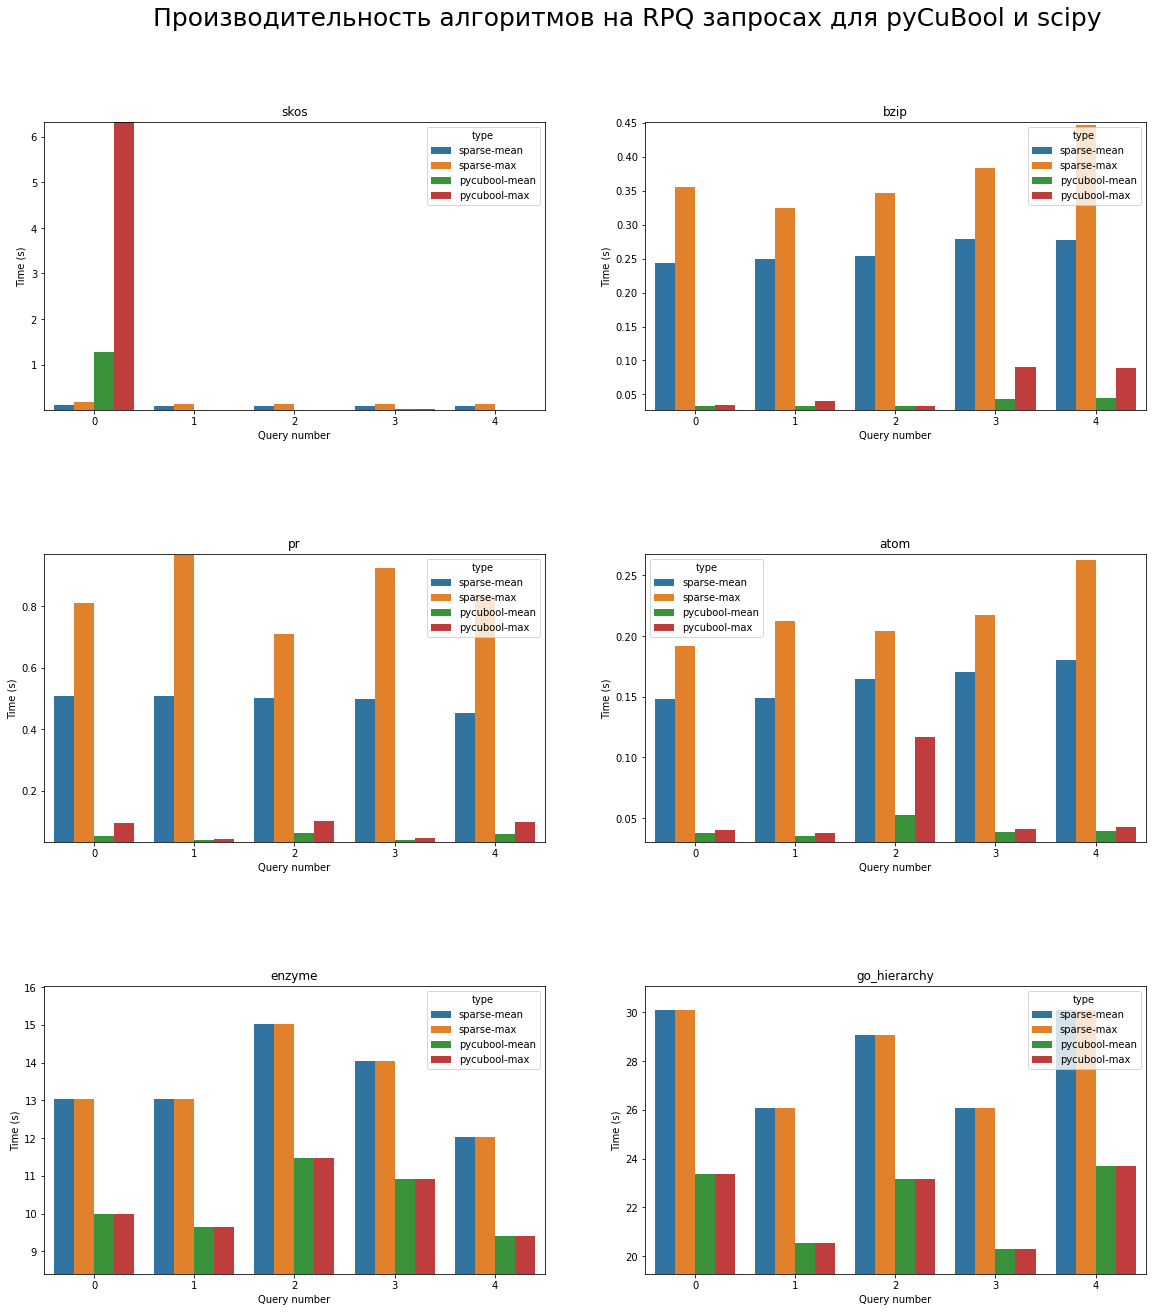

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на RPQ запросах для pyCuBool и scipy', fontsize=25)

for i, graph_name in enumerate(GRAPH_NAMES):
    res_mean_sparse = df_rpq_mean_fix_size[graph_name]
    res_max_sparse = df_rpq_max_fix_size[graph_name]
    res_mean_pycubool = df_cb_rpq_mean_fix_size[graph_name]
    res_max_pycubool = df_cb_rpq_max_fix_size[graph_name]

    df_all = pd.DataFrame(pd.concat([res_mean_sparse, res_max_sparse, res_mean_pycubool, res_max_pycubool], ignore_index=True))
    df_all['type'] = pd.Series(["sparse-mean"] * NUMBER_OF_REGEX + ["sparse-max"] * NUMBER_OF_REGEX +
                               ["pycubool-mean"] * NUMBER_OF_REGEX + ["pycubool-max"] * NUMBER_OF_REGEX)

    ax = sns.barplot(ax=axes[i // 2, i % 2], data=df_all, x=df_all.index % NUMBER_OF_REGEX, y=graph_name, hue="type")

    delta = 0.005
    if graph_name in LARGE_GRAPHS:
        delta = 1
    curr_min = df_all[graph_name].min() - delta
    curr_max = df_all[graph_name].max() + delta
    ax.set(title=graph_name, ylabel="Time (s)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()

##### Вторая задача

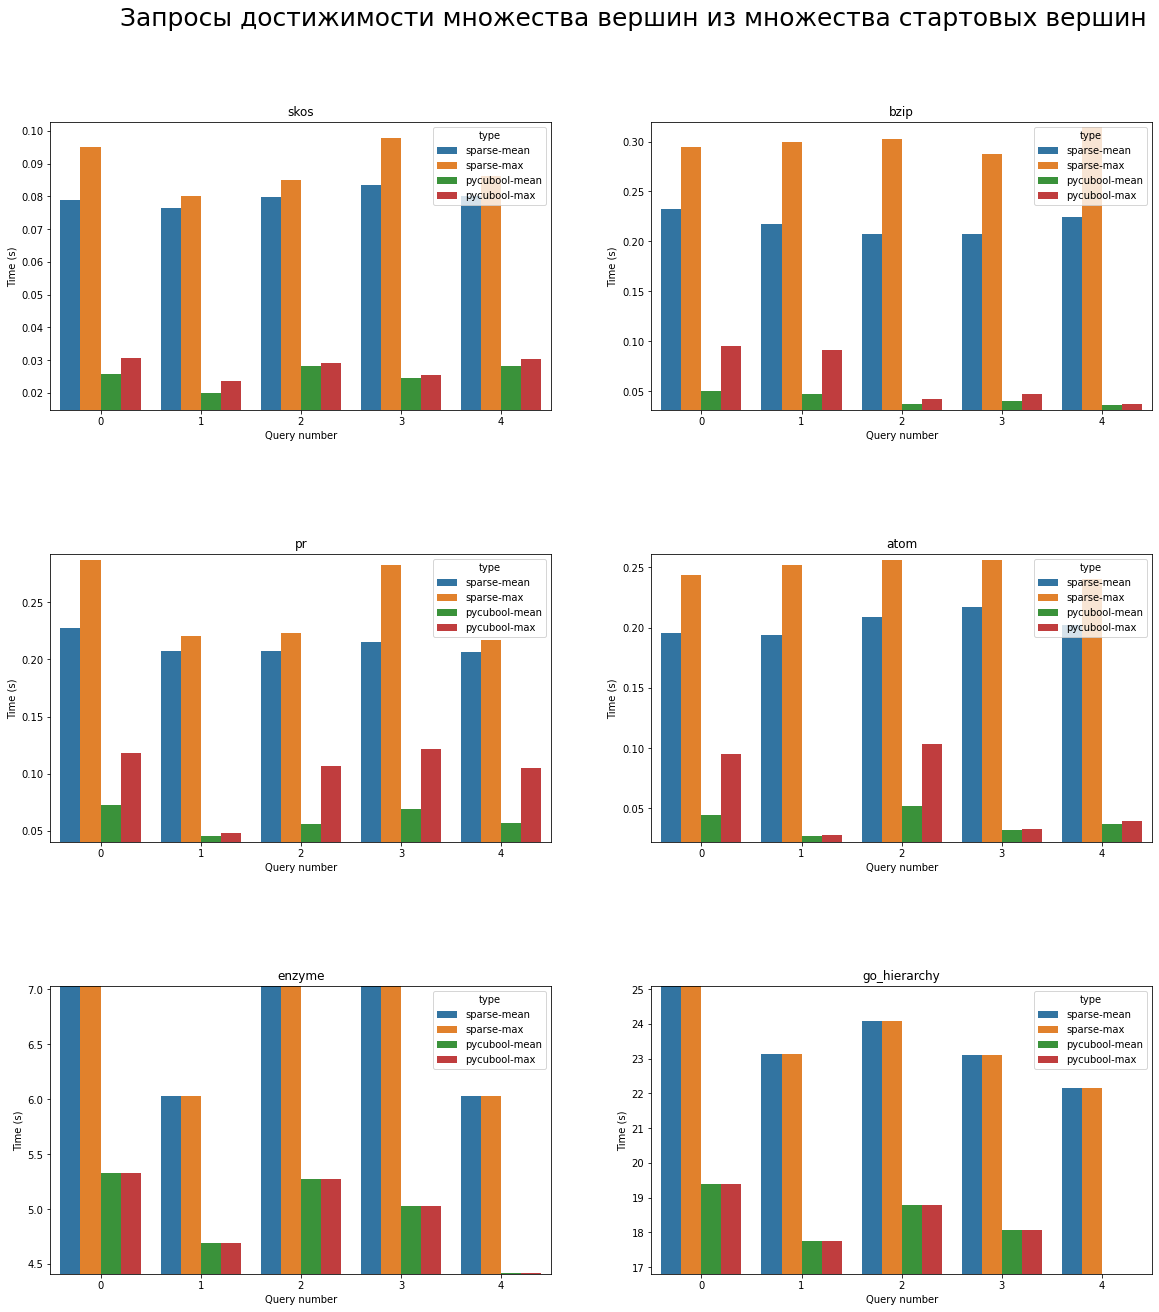

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Запросы достижимости множества вершин из множества стартовых вершин', fontsize=25)

for i, graph_name in enumerate(GRAPH_NAMES):
    res_mean_sparse = df_bfs_ns_rpq_mean_fix_size[graph_name]
    res_max_sparse = df_bfs_ns_rpq_max_fix_size[graph_name]
    res_mean_pycubool = df_cb_bfs_ns_rpq_mean_fix_size[graph_name]
    res_max_pycubool = df_cb_bfs_ns_rpq_max_fix_size[graph_name]

    df_all = pd.DataFrame(pd.concat([res_mean_sparse, res_max_sparse, res_mean_pycubool, res_max_pycubool], ignore_index=True))
    df_all['type'] = pd.Series(["sparse-mean"] * NUMBER_OF_REGEX + ["sparse-max"] * NUMBER_OF_REGEX +
                               ["pycubool-mean"] * NUMBER_OF_REGEX + ["pycubool-max"] * NUMBER_OF_REGEX)

    ax = sns.barplot(ax=axes[i // 2, i % 2], data=df_all, x=df_all.index % NUMBER_OF_REGEX, y=graph_name, hue="type")

    delta = 0.005
    
    curr_min = df_all[graph_name].min() - delta
    curr_max = df_all[graph_name].max() + delta
    ax.set(title=graph_name, ylabel="Time (s)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()

##### Третья задача

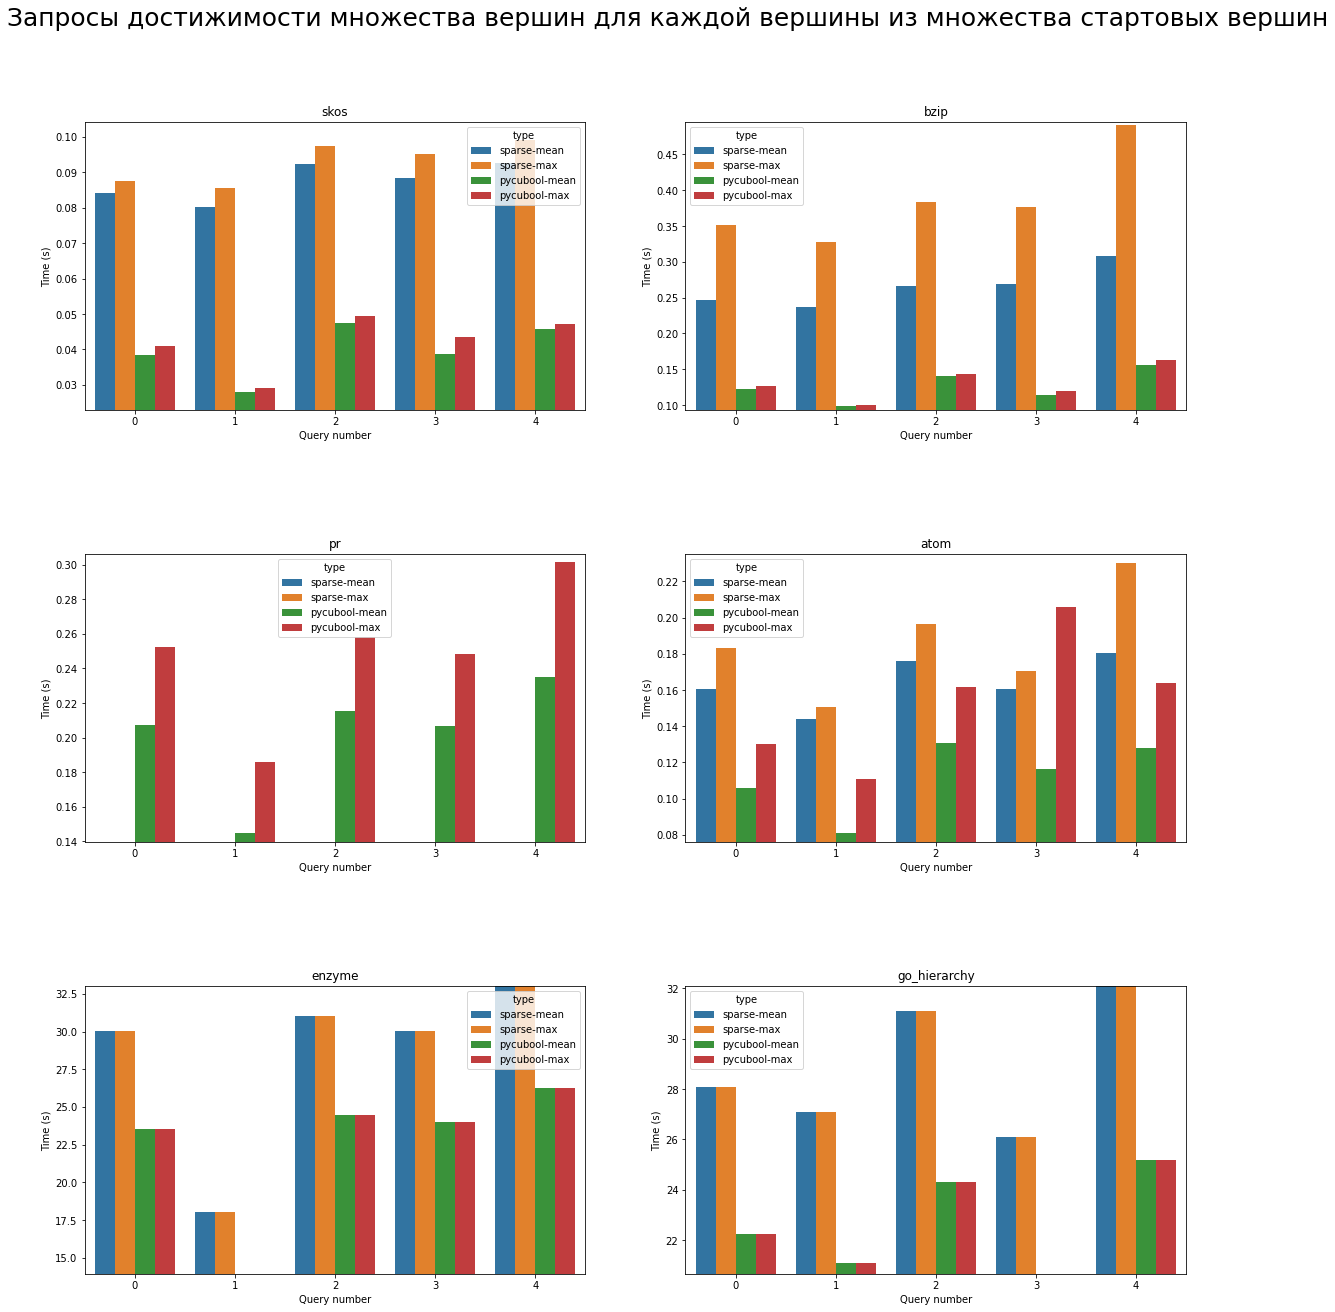

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Запросы достижимости множества вершин '
             'для каждой вершины из множества стартовых вершин', fontsize=25)

for i, graph_name in enumerate(GRAPH_NAMES):
    res_mean_sparse = df_bfs_sep_rpq_mean_fix_size[graph_name]
    res_max_sparse = df_bfs_sep_rpq_max_fix_size[graph_name]
    res_mean_pycubool = df_cb_bfs_sep_rpq_mean_fix_size[graph_name]
    res_max_pycubool = df_cb_bfs_sep_rpq_max_fix_size[graph_name]

    df_all = pd.DataFrame(pd.concat([res_mean_sparse, res_max_sparse, res_mean_pycubool, res_max_pycubool], ignore_index=True))
    df_all['type'] = pd.Series(["sparse-mean"] * NUMBER_OF_REGEX + ["sparse-max"] * NUMBER_OF_REGEX +
                               ["pycubool-mean"] * NUMBER_OF_REGEX + ["pycubool-max"] * NUMBER_OF_REGEX)

    ax = sns.barplot(ax=axes[i // 2, i % 2], data=df_all, x=df_all.index % NUMBER_OF_REGEX, y=graph_name, hue="type")

    delta = 0.005
    
    curr_min = df_all[graph_name].min() - delta
    curr_max = df_all[graph_name].max() + delta
    ax.set(title=graph_name, ylabel="Time (s)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()

### Замеры второй части (переменное множество стартовых вершин)

##### Замеры RPQ запросов для первой части

Время работы `pycubool` на маленьких графах

In [52]:
%%capture

print("=== RPQ BASED ON pycubool ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(rpqCB, graph_name, METAPARAMS, LAUNCH_AT_SMALL, dataframes=[df_cb_rpq_mean, df_cb_rpq_max], description=metaparams_desc)

Время работы `pycubool` на больших графах


In [53]:
%%capture

print("=== RPQ BASED ON pycubool ===")
for graph_name in LARGE_GRAPHS:
    run_and_measure_rpq(rpqCB, graph_name, METAPARAMS, LAUNCH_AT_LARGE, dataframes=[df_cb_rpq_mean, df_cb_rpq_max], description=metaparams_desc)

##### Замеры $RPQ_{BFS}$ запросов для третьей задачи

Время работы `pycubool` на маленьких графах

На основе полученного времени для реализации $RPQ$ выставим верхнюю границу ожидания результата для реализации $RPQ_{BFS}$

In [54]:
TIMEOUTS = {graph_name: list(df_cb_rpq_max[graph_name]) for graph_name in SMALL_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [55]:
%%capture

print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in SMALL_GRAPHS:
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS, 
                        LAUNCH_AT_SMALL, 
                        dataframes=[df_cb_bfs_sep_rpq_mean, df_cb_bfs_sep_rpq_max], 
                        description=metaparams_desc, 
                        separated=True)

Время работы `pycubool` на больших графах

На основе полученного времени для реализации $RPQ$ выставим верхнюю границу ожидания результата для реализации $RPQ_{BFS}$


In [56]:
TIMEOUTS = {graph_name: list(df_cb_rpq_max[graph_name]) for graph_name in LARGE_GRAPHS}
for key in TIMEOUTS:
    TIMEOUTS[key] = list(map(lambda x: 1.25 * x, TIMEOUTS[key]))

In [57]:
%%capture

print("=== RPQ BFS BASED ON pycubool ===")
for graph_name in LARGE_GRAPHS:
    run_and_measure_rpq(cb_bfs_rpq, 
                        graph_name, 
                        METAPARAMS, 
                        LAUNCH_AT_LARGE, 
                        dataframes=[df_cb_bfs_sep_rpq_mean, df_cb_bfs_sep_rpq_max], 
                        description=metaparams_desc, 
                        separated=True,
                        timeouts=TIMEOUTS[graph_name])

#### Результаты замеров

##### Первая задача

Среднее время выполнения реализации на `pycubool`

In [58]:
df_cb_rpq_mean

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3 0.005,0.01701,0.043431,0.09015,0.025624,5.609034,17.898016
(l0 | l1 | l2)* l3 0.01,0.019242,0.043181,0.03881,0.025891,8.444168,19.976571
(l0 | l1 | l2)* l3 0.015,0.017922,0.068619,0.039245,0.028004,8.06264,19.833427
(l0 | l1 | l2)* l3 0.02,0.016476,0.042369,0.042367,0.025686,11.434856,22.35743
(l0 | l1 | l2)* l3 0.05,0.01646,0.045418,0.044309,0.043842,18.490283,29.787418
(l0 | l2)+ l1* 0.005,0.013787,0.064478,0.071336,0.024891,7.552061,16.483739
(l0 | l2)+ l1* 0.01,0.013946,0.042886,0.04063,0.024017,6.723958,18.829336
(l0 | l2)+ l1* 0.015,0.014188,0.044241,0.03942,0.024887,9.642214,20.920416
(l0 | l2)+ l1* 0.02,0.013765,0.058755,0.040375,0.025079,11.552935,19.451321
(l0 | l2)+ l1* 0.05,0.01383,0.046243,0.061079,0.025197,18.762388,29.441383


Максимальное время выполнения реализации на `pycubool`

In [59]:
df_cb_rpq_max

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3 0.005,0.018288,0.058258,0.124865,0.034537,5.609034,17.898016
(l0 | l1 | l2)* l3 0.01,0.024673,0.061105,0.039475,0.038362,8.444168,19.976571
(l0 | l1 | l2)* l3 0.015,0.021228,0.157834,0.039714,0.048015,8.06264,19.833427
(l0 | l1 | l2)* l3 0.02,0.01778,0.058005,0.047785,0.037666,11.434856,22.35743
(l0 | l1 | l2)* l3 0.05,0.017792,0.061965,0.049001,0.111004,18.490283,29.787418
(l0 | l2)+ l1* 0.005,0.014891,0.172041,0.121103,0.037786,7.552061,16.483739
(l0 | l2)+ l1* 0.01,0.015353,0.066806,0.045591,0.036492,6.723958,18.829336
(l0 | l2)+ l1* 0.015,0.015201,0.07169,0.039991,0.038833,9.642214,20.920416
(l0 | l2)+ l1* 0.02,0.014941,0.11027,0.041472,0.036847,11.552935,19.451321
(l0 | l2)+ l1* 0.05,0.0149,0.067704,0.127675,0.038165,18.762388,29.441383


##### Третья задача

Среднее время выполнения реализации на `pycubool`

In [60]:
df_cb_bfs_sep_rpq_mean

,skos,bzip,pr,atom,enzyme,go_hierarchy
(l0 | l1 | l2)* l3 0.005,0.027751,0.059127,0.089226,0.038156,8.000101,19.388318
(l0 | l1 | l2)* l3 0.01,0.026813,0.080653,0.143298,0.053607,11.000372,19.036364
(l0 | l1 | l2)* l3 0.015,0.042183,0.114206,0.190635,0.083037,11.000128,19.47817
(l0 | l1 | l2)* l3 0.02,0.043538,0.138027,0.230545,0.096959,15.000716,20.582017
(l0 | l1 | l2)* l3 0.05,0.11844,0.336305,0.481831,0.229766,24.000535,26.355143
(l0 | l2)+ l1* 0.005,0.021411,0.059379,0.073062,0.045844,8.613886,18.385934
(l0 | l2)+ l1* 0.01,0.021064,0.078779,0.115004,0.04111,9.000077,19.25186
(l0 | l2)+ l1* 0.015,0.031179,0.104782,0.140838,0.072409,12.880888,19.94202
(l0 | l2)+ l1* 0.02,0.030827,0.14376,0.169603,0.085975,15.000189,20.573575
(l0 | l2)+ l1* 0.05,0.082096,0.252965,0.316968,0.160181,24.000145,25.886698


Максимальное время выполнения реализации на `pycubool`

In [61]:
df_cb_bfs_sep_rpq_max

Exception: ignored

                                   skos      bzip        pr      atom  \
(l0 | l1 | l2)* l3 0.005       0.030484  0.087323  0.125098  0.052789   
(l0 | l1 | l2)* l3 0.01        0.028216  0.110612  0.215904  0.068861   
(l0 | l1 | l2)* l3 0.015        0.04339  0.161643  0.245858  0.106628   
(l0 | l1 | l2)* l3 0.02        0.047038  0.190633  0.286952  0.122878   
(l0 | l1 | l2)* l3 0.05        0.127399  0.430875  0.580121  0.289759   
(l0 | l2)+ l1* 0.005           0.022763  0.078854  0.095121  0.102625   
(l0 | l2)+ l1* 0.01            0.023335  0.102522   0.16122  0.054804   
(l0 | l2)+ l1* 0.015            0.03349  0.136045  0.190706  0.131209   
(l0 | l2)+ l1* 0.02            0.033611  0.241684  0.217862  0.186626   
(l0 | l2)+ l1* 0.05             0.08443  0.307123  0.412055  0.212851   
l0 l1 l2 (l3 | l1)* 0.005       0.05121  0.088527  0.231294  0.061124   
l0 l1 l2 (l3 | l1)* 0.01       0.048145   0.17823  0.179689  0.131808   
l0 l1 l2 (l3 | l1)* 0.015      0.075105  0.166393  

#### Диаграмма времени исполнения

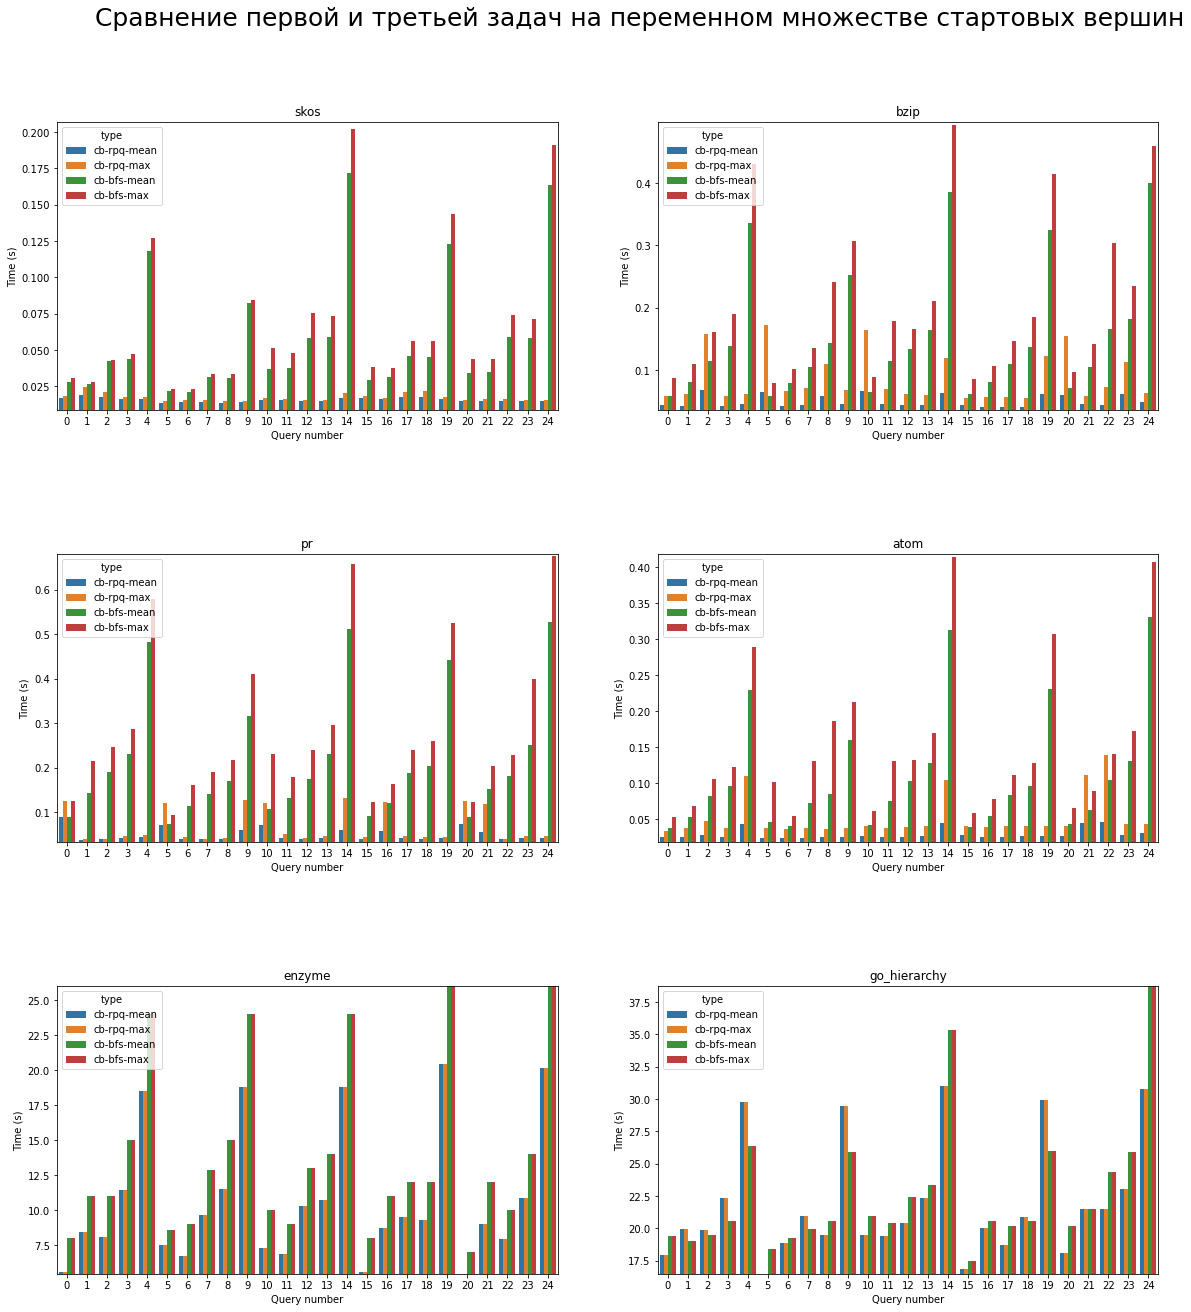

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Сравнение первой и третьей задач на переменном множестве стартовых вершин', fontsize=25)

for i, graph_name in enumerate(GRAPH_NAMES):
    rpq_mean_pycubool = df_cb_rpq_mean[graph_name]
    rpq_max_pycubool = df_cb_rpq_max[graph_name]
    bfs_mean_pycubool = df_cb_bfs_sep_rpq_mean[graph_name]
    bfs_max_pycubool = df_cb_bfs_sep_rpq_max[graph_name]

    df_all = pd.DataFrame(pd.concat([rpq_mean_pycubool, rpq_max_pycubool, bfs_mean_pycubool, bfs_max_pycubool], ignore_index=True))
    df_all['type'] = pd.Series(["cb-rpq-mean"] * NUMBER_OF_REGEX * NUMBER_SIZE + ["cb-rpq-max"] * NUMBER_OF_REGEX * NUMBER_SIZE +
                               ["cb-bfs-mean"] * NUMBER_OF_REGEX * NUMBER_SIZE + ["cb-bfs-max"] * NUMBER_OF_REGEX * NUMBER_SIZE)

    ax = sns.barplot(ax=axes[i // 2, i % 2], data=df_all, x=df_all.index % (NUMBER_OF_REGEX * NUMBER_SIZE), y=graph_name, hue="type")

    delta = 0.005
    
    curr_min = df_all[graph_name].min() - delta
    curr_max = df_all[graph_name].max() + delta
    ax.set(title=graph_name, ylabel="Time (s)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()

## Заключение
Таким образом, исходя из полученных результатов, для графов с числом вершин до $50 000$ и числом рёбер до $500 000$ можно сформировать следующие ответы на поставленные вопросы относительно задачи достижимости в графе с регулярными ограничениями и её решений, основанных на линейной алгебре:

1. Для решений всех задач реализация, использующая технологию `GPGPU` через библиотеку `pycubool`, показывает себя лучше реализации на `scipy.sparse`. 


2. При использовании `pycubool` на маленьких графах для множества стартовых вершин в размере до $15\%$ выгоднее решать задачу достижимости через раздельный $BFS$. Но с ростом размера графов преимущество раздельного поиска теряется и становится выгоднее для любого размера множества стартовых вершин решать задачу достижимости между всеми парами вершин и выбирать нужные.


3. При использовании `pycubool` нахождение множества достижимых вершин из множества стартовых вершин (вторая задача) на маленьких графах сравнимо по времени исполнения с поиском множества достижимых вершин для каждой вершины из стартового множества (третья задача). Но при росте размера графа время исполнения второй задачи растёт существенно медленнее, чем время исполнения третьей задачи.